In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import xarray as xr
import numpy as np
import pandas as pd

import ecephys_analyses as ea 
from ecephys.plot import plot_hypnogram_overlay

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [18]:
xr.set_options(keep_attrs=True)

In [26]:
subject = 'Segundo'
experiment = 'novel_objects_deprivation'
condition = 'light-period-circadian-match'

f_range = (0.5, 4)

In [27]:
hyp = ea.load_hypnogram(subject, experiment, condition)
pwr = ea.load_power(subject, experiment, condition, "spg.nc").sel(frequency=slice(*f_range)).sum(dim="frequency")
spws = ea.load_spws(subject, experiment, condition, abs_sink=True)

In [28]:
def add_epoch(spws, epochs):
    spws = spws.copy()
    def get_epoch(spw):
        idx = epochs.searchsorted(spw.start_time, 'right') - 1
        return epochs.iloc[idx]
    
    spws['epoch'] = spws.apply(get_epoch, axis=1)
    
    return spws

def get_spw_timeseries(spws, epochs, agg_args):
    spws = add_epoch(spws, epochs)
    ts = spws.groupby('epoch').agg(agg_args)
    count_ts = spws.groupby('epoch').size().rename('count')
    return ts.join(count_ts)

In [29]:
ts = get_spw_timeseries(spws, pwr.datetime.to_series(), 'mean')

In [30]:
sum_df = ts.resample('10S').sum().reset_index()
mean_df = ts.resample('10S').mean().reset_index()

In [31]:
def plot_timeseries(df, y_var, ax, fill):
    x_var = 'epoch'
    s = 0.1 if fill else 2
    sns.scatterplot(data=df, x=x_var, y=y_var, color='black', s=s, ax=ax)
    if fill:
        ax.fill_between(df[x_var], df[y_var], color='black')
    
    return ax

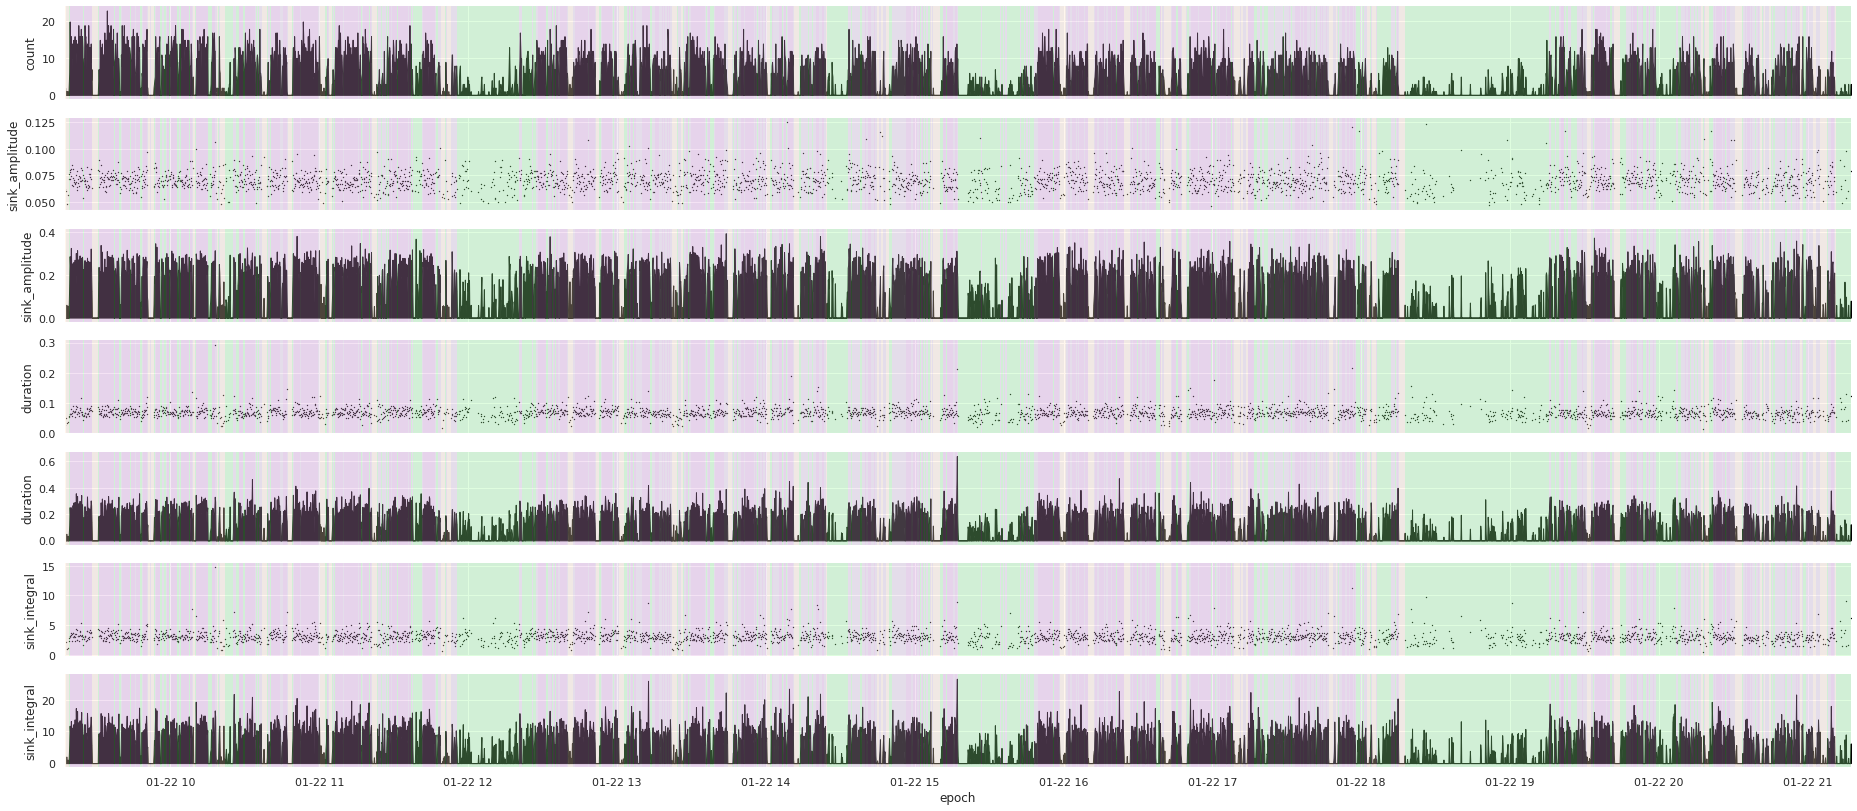

In [32]:
fig, axes = plt.subplots(7, 1, figsize=(32, 14))
plot_timeseries(sum_df, 'count', axes[0], True)
plot_timeseries(mean_df, 'sink_amplitude', axes[1], False)
plot_timeseries(sum_df, 'sink_amplitude', axes[2], True)
plot_timeseries(mean_df, 'duration', axes[3], False)
plot_timeseries(sum_df, 'duration', axes[4], True)
plot_timeseries(mean_df, 'sink_integral', axes[5], False)
plot_timeseries(sum_df, 'sink_integral', axes[6], True)

for ax in axes:
    ax.set(xmargin=0)
    plot_hypnogram_overlay(hyp, ax=ax)
    if ax != axes[-1]:
        ax.set(xlabel=None, xticklabels=[])
    
sns.despine()